The dask package can be run on a single machine or on a cluster. In this notebook, we will explore using dask on a single machine whilst introducing fundamental concepts and classes used by dask. Many of the concepts that are discussed here are portable to other Big Data processing frameworks such as Apache Spark.

# Dask array

A dask array is a distributed version of a numpy array. It can be created from a numpy array however this is not very useful because this would imply that the numpy array already fits on memory--there is no strong need then for the use of dask.

In [1]:
import numpy as np
import dask.array as da

When creating a dask array, the `chunks` parameter is required. It can be the size of each chunk, the shape of each chunk or explicit sizes of all blocks along all dimensions.

In [2]:
darr = da.from_array(np.random.rand(1000,1000), chunks=(100,100))

Like a numpy array, a dask array supports slicing.

In [3]:
darr[:10,:10]

dask.array<getitem, shape=(10, 10), dtype=float64, chunksize=(10, 10)>

However, unlike in numpy or with the sort of Python programming you've experienced so far in MSDS, for most dask operations, invoking a dask operation won't perform the operation immediately. Rather, the invoked operations are used to create a directed acyclic graph (DAG), a dask graph, of tasks to be executed. This allows the workflow (dask graph) to be simplified. To execute the dask graph, call `compute`.

In [4]:
darr[:10,:10].compute()

array([[0.02219676, 0.47831807, 0.05519718, 0.60122203, 0.69159748,
        0.54533311, 0.38558543, 0.67563266, 0.66738627, 0.08468635],
       [0.3103189 , 0.73986161, 0.97715214, 0.56946984, 0.71199478,
        0.81688153, 0.86049998, 0.49787247, 0.47228053, 0.81920774],
       [0.55092418, 0.54589758, 0.70051649, 0.44411405, 0.57715408,
        0.14407961, 0.01057124, 0.91598482, 0.1780914 , 0.53319246],
       [0.49129285, 0.89993021, 0.64598184, 0.0334515 , 0.63135763,
        0.85208505, 0.71648644, 0.91351281, 0.39522226, 0.53758874],
       [0.04814484, 0.31024045, 0.9046893 , 0.25401889, 0.55225702,
        0.83830254, 0.03936691, 0.02403934, 0.63714459, 0.42186437],
       [0.52358818, 0.86344369, 0.98789916, 0.14088243, 0.31193716,
        0.83753968, 0.01801809, 0.26071672, 0.7069291 , 0.34383691],
       [0.18835214, 0.76212829, 0.82252281, 0.04621429, 0.23779026,
        0.19259287, 0.04696069, 0.8491075 , 0.81929963, 0.4291925 ],
       [0.56720714, 0.24566162, 0.9669153

Many numpy array methods and functions are supported by dask arrays. For example, element-by-element operations are allowed.

In [5]:
(darr**2).compute()

array([[4.92696076e-04, 2.28788172e-01, 3.04672856e-03, ...,
        3.02419507e-01, 7.42267043e-01, 7.07834952e-01],
       [9.62978200e-02, 5.47395202e-01, 9.54826307e-01, ...,
        5.18951624e-01, 1.28156207e-01, 1.81152365e-02],
       [3.03517447e-01, 2.98004166e-01, 4.90723352e-01, ...,
        1.64337549e-01, 2.65377575e-02, 1.11207080e-03],
       ...,
       [1.88341630e-01, 6.47087745e-03, 2.01606778e-01, ...,
        7.21515987e-02, 5.03402305e-03, 3.43779195e-01],
       [1.52429248e-01, 6.54139445e-01, 5.84609013e-01, ...,
        2.26019095e-01, 6.80956546e-01, 5.17994388e-02],
       [7.25931379e-01, 3.88400447e-03, 3.06361210e-01, ...,
        5.41178958e-02, 2.31064983e-01, 2.63408038e-01]])

So is the `shape` property but it doesn't require `compute` to evaluate its value.

In [6]:
darr.shape

(1000, 1000)

An overview of the supported operations of dask array is found in the [dask array documentation](http://dask.pydata.org/en/latest/array.html).

The dask graph can be displayed using the `visualize` method. Basically, any dask class that has the `compute` method also has a `visualize` method.

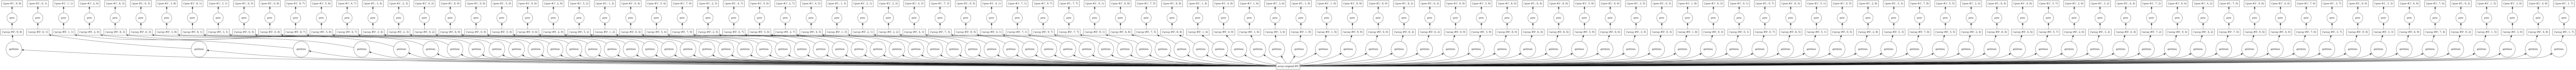

In [7]:
(darr**2).visualize()

In [8]:
darr.mean().visualize()

More information about the [dask graph](http://dask.pydata.org/en/latest/graphs.html) especially for a [dask array](http://dask.pydata.org/en/latest/array-design.html) are found in the documentation.

Input data in dask is divided into chunks or partitions. Tasks are executed by partition. To get the number of partitions, use the `npartitions` property.

In [9]:
darr.npartitions

100

The `dask.array` package has the `random` module which provides a more convenient method of creating random arrays, especially those that don't fit on a single-computer memory.

In [10]:
darr_rand = da.random.random((100000, 100000), (1000,1000))

In [11]:
darr_rand.shape

(100000, 100000)

In [12]:
darr_rand.mean().compute()

0.5000017529167237

# Dask Bag

In [13]:
import dask.bag as db

A dask bag is similar to a multiset. It allows values to be repeated and there's no guarantee on the order of their contents. It is a very flexible class which can be used to read unstructured, semi-structured and structured data.

## Working with semi-structured data

As an example, let us work with tweets that are stored in several compressed (`bz2`) files with each individual tweet stored as a single-line JSON.

When the input string contains a wildcard, it will automatically read all files following the wildcard pattern (glob string) as if they were just a single file.

In [14]:
import json
tweets = db.read_text('/mnt/data/public/twitter/sample/data-1806232*.json.bz2')

Unlike lists or sets, the number of items in a dask bag cannot be return using the `len` function. Instead, you must call the `count` method.

In [15]:
tweets.count()

In [16]:
tweets.count().compute()

586364

To display `k` elements from the bag, call the `take` method. It will only return elements from the first `npartitions`, however, since it is a bag, there is no guarantee as to which partition will be the first.

In [17]:
tweets.take(2)

('{"created_at": "Sat Jun 23 20:00:01 +0000 2018", "id": 1010613467760361472, "id_str": "1010613467760361472", "text": "RT @moonightJK: Bless this gif for holding such immense power of The Kims \\n\\n@BTS_twt #BTS\\n#ChoiceInternationalArtist \\n#TeenChoice https://t\\u2026", "source": "<a href=\\"http://twitter.com/download/iphone\\" rel=\\"nofollow\\">Twitter for iPhone</a>", "truncated": false, "in_reply_to_status_id": null, "in_reply_to_status_id_str": null, "in_reply_to_user_id": null, "in_reply_to_user_id_str": null, "in_reply_to_screen_name": null, "user": {"id": 994615756120776704, "id_str": "994615756120776704", "name": "jungkooks nips conspiracy theory", "screen_name": "Jeonahaha", "location": null, "url": null, "description": "just a fan account trying to sell tickets lol oh and memes", "translator_type": "none", "protected": false, "verified": false, "followers_count": 50, "friends_count": 140, "listed_count": 0, "favourites_count": 3208, "statuses_count": 1780, "created_at

The `pluck` method selects an item from every element in the collection. Calling `pluck(foo)` is like performing the list comprehension `[elem[foo] for elem in bag]`.

In [18]:
tweets.pluck(0).compute()

['{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{',
 '{'

Since the elements in `tweets` are strings, the result of the above operation is the first character of each element. To display the result of 10 elements only (from the first partition, whichever it is), chain a `take` call.

In [19]:
tweets.pluck(0).take(10)

('{', '{', '{', '{', '{', '{', '{', '{', '{', '{')

For us to more efficiently work with the JSON data, we parse each element by passing it to `json.loads`. The resulting JSON object can then be indexed to extract the desired information. To pass each element to a function, use the `map` method. As an example, we extract the `user` information of each tweet. For this particular dataset however, not all elements have a `user` information so we assign a default value to avoid raising exceptions.

In [20]:
tweets.map(json.loads).pluck('user', {}).take(10)

({'contributors_enabled': False,
  'created_at': 'Thu May 10 16:30:50 +0000 2018',
  'default_profile': False,
  'default_profile_image': False,
  'description': 'just a fan account trying to sell tickets lol oh and memes',
  'favourites_count': 3208,
  'follow_request_sent': None,
  'followers_count': 50,
  'following': None,
  'friends_count': 140,
  'geo_enabled': False,
  'id': 994615756120776704,
  'id_str': '994615756120776704',
  'is_translator': False,
  'lang': 'en',
  'listed_count': 0,
  'location': None,
  'name': 'jungkooks nips conspiracy theory',
  'notifications': None,
  'profile_background_color': '000000',
  'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png',
  'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png',
  'profile_background_tile': False,
  'profile_banner_url': 'https://pbs.twimg.com/profile_banners/994615756120776704/1525979911',
  'profile_image_url': 'http://pbs.twimg.com/profile_imag

To select deeper-level elements of the JSON data, chain the `pluck` calls.

In [21]:
tweets.map(json.loads).pluck('user', {}).pluck('screen_name', '').take(10)

('Jeonahaha',
 'souroudes',
 '',
 'becausemiv',
 '97JlNSOUL',
 '',
 '',
 'Abdulkarimaami2',
 'LAFloV',
 'lIMGWVIl')

To select particular elements based on some criteria, use the `filter` method which also requires a function argument similar to `map`. Only elements that evaluate to a `True` value when passed to the function are returned.

In [22]:
tweets.map(json.loads).filter(lambda x: 'user' not in x).count().compute()

172271

For the next examples, we further reduce the dataset to make their runtime more manageable.

In [23]:
tweets2 = tweets.map(json.loads).random_sample(0.05, 42)

The `frequencies` method counts the frequencies of each element. The output of the cell below may differ across different runs and machines because the output of `frequencies` has no guaranteed order.

In [24]:
tweets2.pluck('user', {}).pluck('screen_name', '').frequencies().take(10)

(('', 8656),
 ('Lenin_Salinas_', 1),
 ('_unisan_', 1),
 ('JuanDanielMio3', 1),
 ('Mima_nzl', 1),
 ('veraa_ldt', 1),
 ('taxydromosvolos', 1),
 ('KateMimosa', 1),
 ('onry_i', 1),
 ('pau_stokely', 1))

By forcing the output to be sorted, the output of the cell below is consistent across runs and machines. Instead of using `\` to break a source code line into multiple lines, a cleaner approach is to enclose the line inside parentheses.

In [25]:
(tweets2.pluck('user', {})
        .pluck('screen_name', '')
        .frequencies()
        .topk(10, key=lambda x: x[1])
        .compute())

[('', 8656),
 ('Alwan_media', 8),
 ('Pizza_Hut_Japan', 4),
 ('andersontj08', 3),
 ('test5f1798', 3),
 ('googuns_lulz', 3),
 ('Yoggu2', 3),
 ('ank1923m_uysal', 2),
 ('AliIttiNG', 2),
 ('1125E', 2)]

The entire dask graph is evaluated every time `compute` is called. If there is a particular sequence of calls, which corresponds to a subgraph, that is being frequently called, then it would be better to store their result on memory so that the subgraph won't be evaluated next time. We do this by calling `persist`. 

Note that there should be sufficient memory to store the subgraph results otherwise the call would fail. It should also be called on frequently used subgraphs only because the time and space overhead costs of `persist` are significant.

In [26]:
tweets3 = tweets2.persist()

Compare the execution time of the cell below with the execution time of a similar cell above.

In [27]:
tweets3.pluck('user', {}).pluck('screen_name', '').frequencies().take(10)

(('', 8656),
 ('Lenin_Salinas_', 1),
 ('_unisan_', 1),
 ('JuanDanielMio3', 1),
 ('Mima_nzl', 1),
 ('veraa_ldt', 1),
 ('taxydromosvolos', 1),
 ('KateMimosa', 1),
 ('onry_i', 1),
 ('pau_stokely', 1))

Do the comparison again for the cell below. Why is the output of the cell below different from the output of the cell above?

In [28]:
# why are the results different from above?
tweets3.pluck('user', {}).pluck('screen_name', '').frequencies().topk(10, key=lambda x: x[1]).compute()

[('', 8656),
 ('Alwan_media', 8),
 ('Pizza_Hut_Japan', 4),
 ('andersontj08', 3),
 ('test5f1798', 3),
 ('googuns_lulz', 3),
 ('Yoggu2', 3),
 ('ank1923m_uysal', 2),
 ('AliIttiNG', 2),
 ('1125E', 2)]

If several operations have similar dask graphs, then it would be better to call `compute` at the same time so that temporary results can be shared among all graphs. We also demonstrate the use of `itemgetter` below.

In [29]:
from operator import itemgetter
db.compute(tweets2.pluck('user', {})
                  .pluck('screen_name', '')
                  .frequencies()
                  .topk(10, key=itemgetter(1)),
           tweets2.pluck('user', {})
                  .pluck('followers_count', 0)
                  .topk(10))

([('', 8656),
  ('Alwan_media', 8),
  ('Pizza_Hut_Japan', 4),
  ('andersontj08', 3),
  ('test5f1798', 3),
  ('googuns_lulz', 3),
  ('Yoggu2', 3),
  ('ank1923m_uysal', 2),
  ('AliIttiNG', 2),
  ('1125E', 2)],
 [3077549,
  2396474,
  2098843,
  1695623,
  1654125,
  1602667,
  1157831,
  1067567,
  955093,
  836189])

Due to the sheer amount of data we work with, knowing the realtime progress of our computation is very useful. `dask` has `ProgressBar` to give us that.

In [30]:
from dask.diagnostics import ProgressBar

In [31]:
with ProgressBar():
    print(db.zip(tweets2.pluck('user', {}).pluck('screen_name', ''),
                 tweets2.pluck('user', {}).pluck('followers_count', 0))
            .topk(10, itemgetter(1))
            .compute())

[########################################] | 100% Completed | 42.0s
[('aawsat_News', 3077549), ('KLM', 2396474), ('WatanNews', 2098843), ('Cruz_Azul_FC', 1695623), ('Du3aa', 1654125), ('Fact_Footba11', 1602667), ('NasimZehra', 1157831), ('dailytxtmsg', 1067567), ('dmofficiale', 955093), ('NoticiasVenezue', 836189)]


We can register a `ProgressBar` so that a progress is displayed every time we perform a dask computation.

In [32]:
pbar = ProgressBar()
pbar.register()

In [33]:
print(db.zip(tweets2.pluck('user', {}).pluck('screen_name', ''),
             tweets2.pluck('user', {}).pluck('followers_count', 0))
        .topk(10, itemgetter(1))
        .compute())

[########################################] | 100% Completed | 41.3s
[('aawsat_News', 3077549), ('KLM', 2396474), ('WatanNews', 2098843), ('Cruz_Azul_FC', 1695623), ('Du3aa', 1654125), ('Fact_Footba11', 1602667), ('NasimZehra', 1157831), ('dailytxtmsg', 1067567), ('dmofficiale', 955093), ('NoticiasVenezue', 836189)]


## Working with Unstructured Data

For this section, we will work with Project Gutenberg data. Although `read_text` allows `*` as a wildcard, we also need the `?` wildcard to restrict the files that we read to those having 5 character filenames. Unfortunately, `read_text` does not support the `?` wildcard so we use `glob` instead to return a list of file paths that satisfy our glob string.

In [34]:
import glob

In [35]:
texts = db.read_text(
    glob.glob('/mnt/data/public/gutenberg/1/1/1/*/*/?????.txt'), 
    errors='ignore')

We count the number of lines in all the books (text files) we read in.

In [36]:
texts.count().compute()

[########################################] | 100% Completed |  0.6s


615201

By default, each book corresponds to one partition. To find out the number of books we read in, display the number of partitions.

In [37]:
texts.npartitions

97

Let's look at two lines.

In [38]:
texts.take(2)

[########################################] | 100% Completed |  0.1s


("Project Gutenberg's History Of Modern Philosophy, by Richard Falckenberg\n",
 '\n')

Suppose we want to make the text of each book into a single line only. To do that, we need to get all the lines that correspond to a single book i.e., a partition, then call `join` on them. The method `map_partitions` passes all the elements of the partition to a function and not just each individual element. We return a single-element list so that the output of all `map_partition`s won't be combined into just a single element.

In [39]:
texts.map_partitions(lambda x: [' '.join(x)]).take(1)

[########################################] | 100% Completed |  0.1s


('Project Gutenberg\'s History Of Modern Philosophy, by Richard Falckenberg\n \n This eBook is for the use of anyone anywhere at no cost and with\n almost no restrictions whatsoever.  You may copy it, give it away or\n re-use it under the terms of the Project Gutenberg License included\n with this eBook or online at www.gutenberg.net\n \n \n Title: History Of Modern Philosophy\n        From Nicolas of Cusa to the Present Time\n \n Author: Richard Falckenberg\n \n Release Date: February 15, 2004 [EBook #11100]\n \n Language: English\n \n Character set encoding: ASCII\n \n *** START OF THIS PROJECT GUTENBERG EBOOK HISTORY OF MODERN PHILOSOPHY ***\n \n \n \n \n Produced by Juliet Sutherland, Lazar Liveanu and PG Distributed\n Proofreaders\n \n \n \n \n \n HISTORY OF MODERN PHILOSOPHY\n \n From Nicolas of Cusa to the Present Time\n \n \n \n by\n \n RICHARD FALCKENBERG\n \n _Professor of Philosophy in the University of Erlangen_\n \n \n \n \n _THIRD AMERICAN FROM THE SECOND GERMAN EDITION_\

To prove that the above chain of operations does combine each book into a single line, we count the number of elements in each partition.

In [40]:
texts.map_partitions(lambda x: [' '.join(x)]).map_partitions(
    lambda x: [len(x)]).compute()

[########################################] | 100% Completed |  0.3s


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

To combine all of the lines into one line, we can perform a reduction operation.

In [41]:
(texts.map_partitions(lambda x: [' '.join(x)])
      .reduction(
          lambda x: x[0], # extract only element in each partition
          lambda x: ' '.join(x)) # append the current partition to the result
      .compute()[:100])

[########################################] | 100% Completed |  2.6s


"Project Gutenberg's History Of Modern Philosophy, by Richard Falckenberg\n \n This eBook is for the us"

The above approach is sequential. A better approach is to evaluate them in parallel using `fold`.

In [42]:
(texts.map_partitions(lambda x: [' '.join(x)])
      .fold(
          lambda x, y: x+' '+y, # concatenate elements in a partition
          lambda x,y: x+' '+y) # concatenate results from partitions
      .compute()[:100])

[########################################] | 100% Completed |  1.4s


"Project Gutenberg's History Of Modern Philosophy, by Richard Falckenberg\n \n This eBook is for the us"

String operations are supported using the `str` property similar to pandas dataframes. In the cell below, we look for the top 10 most frequent tokens where a token is defined as a sequence of lowercase letters bounded by a space.

In [43]:
texts.str.lower().str.strip().str.split(' ').flatten().filter(
    lambda x: len(x)).frequencies().topk(10, itemgetter(1)).compute()

[########################################] | 100% Completed | 23.7s


[('the', 315448),
 ('of', 179141),
 ('and', 160144),
 ('to', 131948),
 ('a', 109655),
 ('in', 88615),
 ('that', 52313),
 ('he', 48449),
 ('was', 48439),
 ('i', 46531)]

# Dask DataFrame

Dask has a dataframe that is used for working with structured data. 

## Working with CSV files

In this example, we work with New York green taxi data for the last quarter of 2017.

In [44]:
import dask.dataframe as dd
trips = dd.read_csv('/mnt/data/public/nyctaxi/all/green_tripdata_2017-1*.csv',
                    delimiter=',', assume_missing=True)

Working with dask dataframes is very similar to pandas dataframes. However, not all features of pandas dataframes are [supported](http://dask.pydata.org/en/latest/dataframe.html).

In [45]:
trips.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type'],
      dtype='object')

In [46]:
trips.count().compute()

[########################################] | 100% Completed | 18.3s


VendorID                 2706150
lpep_pickup_datetime     2706150
lpep_dropoff_datetime    2706150
store_and_fwd_flag       2706150
RatecodeID               2706150
PULocationID             2706150
DOLocationID             2706150
passenger_count          2706150
trip_distance            2706150
fare_amount              2706150
extra                    2706150
mta_tax                  2706150
tip_amount               2706150
tolls_amount             2706150
ehail_fee                      0
improvement_surcharge    2706150
total_amount             2706150
payment_type             2706150
trip_type                2706148
dtype: int64

In [47]:
trips.npartitions

6

In [48]:
trips.head()

[########################################] | 100% Completed |  3.3s


VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0       2.0  2017-10-01 00:27:41   2017-10-01 00:32:45                  N   
1       2.0  2017-10-01 00:56:00   2017-10-01 01:21:49                  N   
2       2.0  2017-10-01 00:27:48   2017-10-01 00:36:48                  N   
3       2.0  2017-10-01 00:24:24   2017-10-01 00:55:38                  N   
4       2.0  2017-10-01 00:24:11   2017-10-01 00:36:27                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0         264.0         193.0              1.0           0.00   
1         1.0          92.0         230.0              1.0          13.98   
2         1.0         112.0         157.0              1.0           1.61   
3         1.0         255.0          48.0              2.0           7.23   
4         1.0         260.0         129.0              1.0           2.31   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0          2.5    0.5      0.5        0.00          0.00        NaN   
1         40.0    0.5      0.5        9.41          5.76        NaN   
2          8.0    0.5      0.5        0.00          0.00        NaN   
3         26.0    0.5      0.5        0.00          0.00        NaN   
4         10.5    0.5      0.5        0.00          0.00        NaN   

   improvement_surcharge  total_amount  payment_type  trip_type  
0                    0.3          3.80           2.0        1.0  
1                    0.3         56.47           1.0        1.0  
2                    0.3          9.30           2.0        1.0  
3                    0.3         27.30           2.0        1.0  
4                    0.3         11.80           2.0        1.0

In [49]:
trips['total_amount'].mean().compute()

[########################################] | 100% Completed | 11.3s


14.379970204903644

In [50]:
trips['trip_distance'].describe().compute()

[########################################] | 100% Completed | 11.9s


count    2.706150e+06
mean     2.711480e+00
std      2.872800e+00
min      0.000000e+00
25%      1.020000e+00
50%      1.800000e+00
75%      3.420000e+00
max      2.200800e+02
dtype: float64

In [51]:
trips['trip_distance'].value_counts().compute()

[########################################] | 100% Completed | 11.5s


1.00      31190
0.90      31184
0.80      31055
0.00      30495
1.10      29385
0.70      28279
1.20      28149
1.30      25818
1.40      24523
0.60      24472
1.50      22137
1.60      20019
0.50      18720
1.70      18312
1.80      17439
1.90      16263
2.00      14870
2.10      13644
2.20      13125
0.40      12445
2.30      12105
2.40      11382
2.50      10820
2.60      10268
2.70       9882
2.80       9645
0.87       9459
0.94       9428
0.88       9377
0.96       9325
          ...  
32.75         1
32.77         1
32.79         1
32.86         1
32.52         1
32.90         1
32.96         1
33.00         1
33.03         1
33.06         1
33.09         1
32.53         1
32.50         1
31.97         1
32.15         1
32.02         1
32.05         1
32.07         1
32.09         1
26.58         1
32.14         1
32.21         1
32.46         1
32.22         1
32.26         1
32.28         1
32.29         1
32.37         1
32.45         1
220.08        1
Name: trip_distance, Len

Dask dataframes do not have visualization methods. Thus, we have to implement them on our own. For example, a histogram of the trip distance is shown below.

[########################################] | 100% Completed | 12.4s


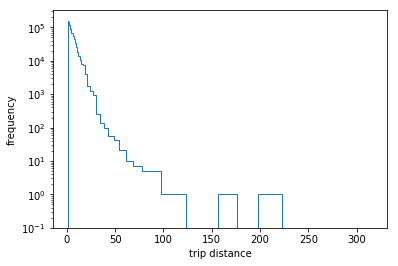

In [52]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
freq = trips['trip_distance'].compute()
plt.hist(freq, bins=np.logspace(0, 2.5), histtype='step', log=True)
plt.xlabel('trip distance')
plt.ylabel('frequency');

The above approach for doing histograms is not advisable though because it collected all trip distances into the main process first, requiring a lot of memory. A better approach is to use a distributed histogram function.

[########################################] | 100% Completed | 11.4s


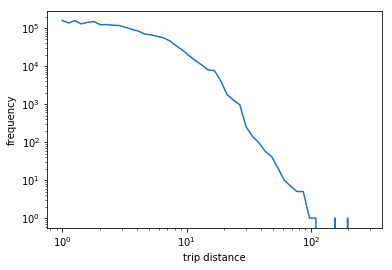

In [53]:
h, bins = da.histogram(trips['trip_distance'], np.logspace(0, 2.5))
freq = h.compute()
plt.loglog(bins[:-1], freq)
plt.xlabel('trip distance')
plt.ylabel('frequency');

Groupby operations are supported as well.

In [54]:
trips.groupby('VendorID')['total_amount'].sum().describe().compute()

[########################################] | 100% Completed | 13.1s


/opt/conda/lib/python3.5/site-packages/pandas/core/indexes/base.py:3078: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


count    2.000000e+00
mean     1.945718e+07
std      1.799629e+07
min      6.731879e+06
25%      1.309453e+07
50%      1.945718e+07
75%      2.581983e+07
max      3.218248e+07
dtype: float64

In [55]:
trips['VendorID'].value_counts().compute()

[########################################] | 100% Completed |  8.3s


2.0    2218377
1.0     487773
Name: VendorID, dtype: int64

However, groupby operations along the index is faster because data is partitioned along the index which avoid shuffling data across processes and machines.

In [56]:
trips2 = trips.set_index('VendorID').persist()

[########################################] | 100% Completed | 10.8s
[########################################] | 100% Completed | 43.1s


In [57]:
trips2.groupby('VendorID')['total_amount'].sum().describe().compute()

[########################################] | 100% Completed |  0.2s


count    2.000000e+00
mean     1.945718e+07
std      1.799629e+07
min      6.731879e+06
25%      1.309453e+07
50%      1.945718e+07
75%      2.581983e+07
max      3.218248e+07
dtype: float64

Compare the execution time of the next couple of cells below with the cell above.

In [58]:
trips3 = trips.set_index('VendorID')

[########################################] | 100% Completed | 16.2s


In [59]:
trips3.groupby('VendorID')['total_amount'].sum().describe().compute()

[########################################] | 100% Completed |  1min 26.8s


count    2.000000e+00
mean     1.945718e+07
std      1.799629e+07
min      6.731879e+06
25%      1.309453e+07
50%      1.945718e+07
75%      2.581983e+07
max      3.218248e+07
dtype: float64

What happens to the execution time if we persist `trips` instead?

In [60]:
trips4 = trips.persist()

[########################################] | 100% Completed | 17.5s


In [61]:
trips4.groupby('VendorID')['total_amount'].sum().describe().compute()

[########################################] | 100% Completed |  4.1s


/opt/conda/lib/python3.5/site-packages/pandas/core/indexes/base.py:3078: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


count    2.000000e+00
mean     1.945718e+07
std      1.799629e+07
min      6.731879e+06
25%      1.309453e+07
50%      1.945718e+07
75%      2.581983e+07
max      3.218248e+07
dtype: float64

## Working with Parquet files

Instead of reading from CSV files, let's read from Parquet files instead.

In [64]:
trips = dd.read_parquet('/mnt/data/public/nyctaxi/green_2017')

We rerun the cells from the previous section. Compare the results and execution times of cells in this section with the corresponding cells of the previous section.

In [65]:
trips.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type'],
      dtype='object')

In [66]:
trips.count().compute()

[########################################] | 100% Completed | 43.5s


VendorID                 11740667
lpep_pickup_datetime     11740667
lpep_dropoff_datetime    11740667
store_and_fwd_flag       11740667
RatecodeID               11740667
PULocationID             11740667
DOLocationID             11740667
passenger_count          11740667
trip_distance            11740667
fare_amount              11740667
extra                    11740667
mta_tax                  11740667
tip_amount               11740667
tolls_amount             11740667
ehail_fee                       0
improvement_surcharge    11740667
total_amount             11740667
payment_type             11740667
trip_type                11740640
dtype: int64

In [67]:
trips.npartitions

24

In [68]:
trips.head()

[########################################] | 100% Completed |  0.8s


VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0       2.0  2017-01-01 00:01:15   2017-01-01 00:11:05                  N   
1       2.0  2017-01-01 00:03:34   2017-01-01 00:09:00                  N   
2       2.0  2017-01-01 00:04:02   2017-01-01 00:12:55                  N   
3       2.0  2017-01-01 00:01:40   2017-01-01 00:14:23                  N   
4       2.0  2017-01-01 00:00:51   2017-01-01 00:18:55                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0          42.0         166.0              1.0           1.71   
1         1.0          75.0          74.0              1.0           1.44   
2         1.0          82.0          70.0              5.0           3.45   
3         1.0         255.0         232.0              1.0           2.11   
4         1.0         166.0         239.0              1.0           2.76   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0          9.0    0.0      0.5        0.00           0.0        NaN   
1          6.5    0.5      0.5        0.00           0.0        NaN   
2         12.0    0.5      0.5        2.66           0.0        NaN   
3         10.5    0.5      0.5        0.00           0.0        NaN   
4         11.5    0.5      0.5        0.00           0.0        NaN   

   improvement_surcharge  total_amount  payment_type  trip_type  
0                    0.3          9.80           2.0        1.0  
1                    0.3          7.80           2.0        1.0  
2                    0.3         15.96           1.0        1.0  
3                    0.3         11.80           2.0        1.0  
4                    0.3         12.80           2.0        1.0

In [69]:
trips['total_amount'].mean().compute()

[########################################] | 100% Completed | 19.4s


14.24200019555959

In [70]:
trips['trip_distance'].describe().compute()

[########################################] | 100% Completed | 19.3s


count    1.174067e+07
mean     2.684420e+00
std      2.828545e+00
min      0.000000e+00
25%      1.050000e+00
50%      1.860000e+00
75%      3.560000e+00
max      6.400000e+02
dtype: float64

In [71]:
trips['trip_distance'].value_counts().compute()

[########################################] | 100% Completed | 17.9s


0.90      142042
1.00      141196
0.80      139963
0.00      135743
1.10      132548
0.70      127269
1.20      125633
1.30      117085
0.60      111291
1.40      109332
1.50       99184
1.60       90864
0.50       86056
1.70       83631
1.80       78331
1.90       73818
2.00       68245
2.10       62890
2.20       60263
0.40       57228
2.30       56095
2.40       52082
2.50       49307
2.60       47276
2.70       45142
2.80       43847
2.90       41371
0.87       40351
0.86       40203
0.88       40165
           ...  
40.96          1
40.89          1
39.94          1
40.84          1
40.04          1
40.06          1
40.10          1
40.11          1
40.13          1
40.16          1
40.17          1
40.19          1
40.26          1
40.32          1
40.34          1
40.35          1
40.38          1
40.42          1
40.43          1
40.47          1
40.50          1
40.54          1
40.55          1
40.60          1
40.61          1
40.64          1
40.69          1
40.76         

[########################################] | 100% Completed | 15.8s


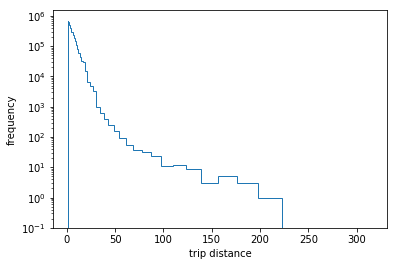

In [72]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
freq = trips['trip_distance'].compute()
plt.hist(freq, bins=np.logspace(0, 2.5), histtype='step', log=True)
plt.xlabel('trip distance')
plt.ylabel('frequency');

[########################################] | 100% Completed | 17.3s


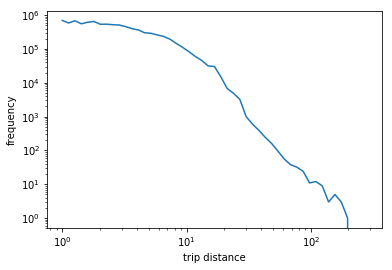

In [73]:
h, bins = da.histogram(trips['trip_distance'], np.logspace(0, 2.5))
freq = h.compute()
plt.loglog(bins[:-1], freq)
plt.xlabel('trip distance')
plt.ylabel('frequency');

In [74]:
trips.groupby('VendorID')['total_amount'].sum().describe().compute()

[########################################] | 100% Completed | 14.9s


count    2.000000e+00
mean     8.360529e+07
std      7.356537e+07
min      3.158672e+07
25%      5.759601e+07
50%      8.360529e+07
75%      1.096146e+08
max      1.356239e+08
dtype: float64

In [75]:
trips['VendorID'].value_counts().compute()

[########################################] | 100% Completed | 16.1s


2.0    9447302
1.0    2293365
Name: VendorID, dtype: int64

In [76]:
trips2 = trips.set_index('VendorID').persist()

[########################################] | 100% Completed | 16.5s
[########################################] | 100% Completed |  1min 33.8s


In [77]:
trips2.groupby('VendorID')['total_amount'].sum().describe().compute()

[########################################] | 100% Completed |  0.9s


count    2.000000e+00
mean     8.360529e+07
std      7.356537e+07
min      3.158672e+07
25%      5.759601e+07
50%      8.360529e+07
75%      1.096146e+08
max      1.356239e+08
dtype: float64

In [78]:
trips3 = trips.set_index('VendorID')

[########################################] | 100% Completed | 16.2s


In [79]:
trips3.groupby('VendorID')['total_amount'].sum().describe().compute()

[########################################] | 100% Completed |  1min 34.1s


count    2.000000e+00
mean     8.360529e+07
std      7.356537e+07
min      3.158672e+07
25%      5.759601e+07
50%      8.360529e+07
75%      1.096146e+08
max      1.356239e+08
dtype: float64

In [80]:
trips4 = trips.persist()

[########################################] | 100% Completed | 13.4s


In [81]:
trips4.groupby('VendorID')['total_amount'].sum().describe().compute()

[########################################] | 100% Completed |  0.2s


count    2.000000e+00
mean     8.360529e+07
std      7.356537e+07
min      3.158672e+07
25%      5.759601e+07
50%      8.360529e+07
75%      1.096146e+08
max      1.356239e+08
dtype: float64